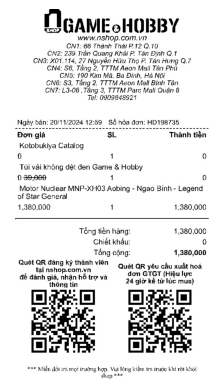

In [53]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import json

# Đọc ảnh
img = cv2.imread("./images/BILL_1.jpg")

def show_image(img):
    if img is None:
        print("Không tìm thấy ảnh")
    else:
        # Hiển thị ảnh
        plt.imshow(img)
        plt.axis("off")
        plt.show()

show_image(img)

In [54]:
! pip install transformers datasets accelerate torchvision

In [55]:
! pip install --upgrade torch torchvision

In [67]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
import datasets
from PIL import Image
import torch
import os
import json
import re

from IPython.display import display

# fine tuning mô hình
processor = DonutProcessor.from_pretrained("Bennet1996/donut-small")
model = VisionEncoderDecoderModel.from_pretrained("Bennet1996/donut-small")
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s>"])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [63]:
import os
os.environ["WANDB_DISABLED"] = "true" # không cảnh báo khi dùng mô hình tren hugging face


Image path: /content/images/BILL_1.jpg


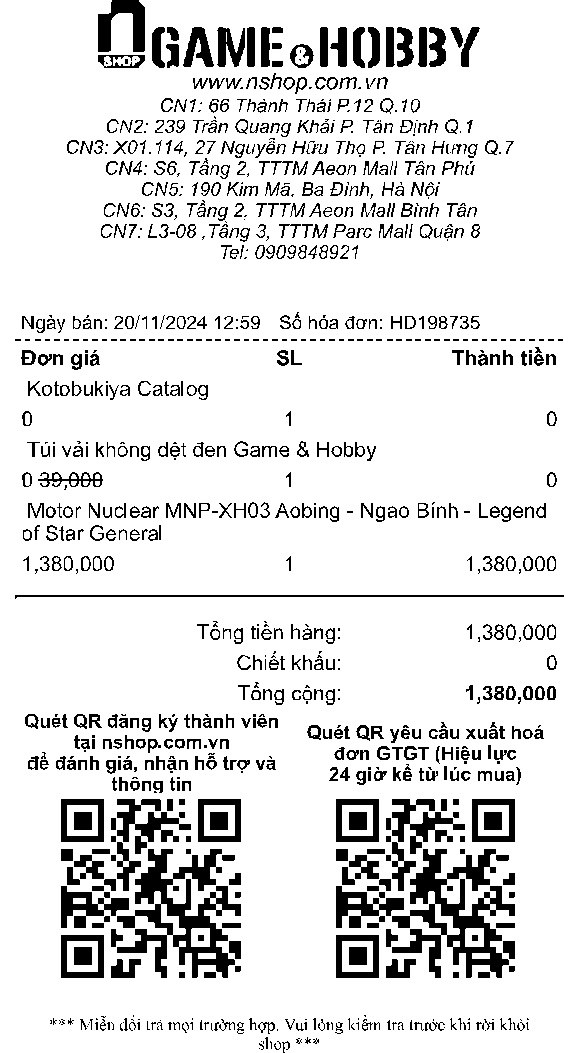

Label: {"invoice_number": "HD198735", "invoice_date": "20/11/2024", "total_amount": "1380000"}


In [ ]:
def load_invoice_data(img_folder, label_folder):
    data = []
    for file in os.listdir(img_folder):
        if file.endswith(".jpg") or file.endswith(".png"):
            img_path = os.path.join(img_folder, file)
            json_path = os.path.join(label_folder, file.replace(".jpg", ".json").replace(".png", ".json"))
            if os.path.exists(json_path):
                with open(json_path, "r", encoding="utf-8") as f:
                    label = json.load(f)
                text_label = json.dumps(label, ensure_ascii=False)
                data.append({"image_path": img_path, "label": text_label})
    return Dataset.from_list(data)


# Load raw data (trước khi map)
raw_dataset = load_invoice_data("./images", "./labels")

# Hiển thị ảnh đầu tiên
img_path = raw_dataset[0]["image_path"]
img = Image.open(img_path).convert("RGB")
print(f"Image path: {img_path}")
display(img)
print("Label:", raw_dataset[0]["label"])





In [65]:
def preprocess(example):
    image = Image.open(example["image_path"]).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0).numpy().tolist()
    labels = processor.tokenizer(
        example["label"], add_special_tokens=False, return_tensors="pt"
    ).input_ids.squeeze(0).tolist()
    return {"pixel_values": pixel_values, "labels": labels}


train_dataset = load_invoice_data("./images", "./labels")
train_dataset = train_dataset.map(
    preprocess,
    remove_columns=train_dataset.column_names,
    features=datasets.Features({
    "pixel_values": datasets.Sequence(
        datasets.Sequence(
            datasets.Sequence(datasets.Value("float32"))
        )
    ),
    "labels": datasets.Sequence(datasets.Value("int64"))
})

)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [69]:
# tham số của việc train mô hình
# Thêm các check point
training_args = Seq2SeqTrainingArguments(
    output_dir="donut-finetuned-invoice",
    per_device_train_batch_size=1,
    num_train_epochs=20,
    logging_dir="./logs",
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    save_total_limit=1,
    remove_unused_columns=False,
    predict_with_generate=True,
    report_to="none"
)

# train mô hình, với các tham số ở trên
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=processor,
)

trainer.train()

# lưu mô hình để có thể sử dụng sau cho việc dự đoán, triển khai
model.save_pretrained("./donut-finetuned-invoice")
processor.save_pretrained("./donut-finetuned-invoice")


/tmp/ipython-input-69-906785209.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss


[]

In [71]:
# dự đoán
def extract_invoice_info(image_path, model_dir="./donut-finetuned-invoice"):
    image = Image.open(image_path).convert("RGB")
    processor_inf = DonutProcessor.from_pretrained(model_dir)
    model_inf = VisionEncoderDecoderModel.from_pretrained(model_dir)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_inf.to(device)

    task_prompt = "<s_invoice>"
    decoder_input_ids = processor_inf.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    pixel_values = processor_inf(image, return_tensors="pt").pixel_values

    outputs = model_inf.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=512,
        pad_token_id=processor_inf.tokenizer.pad_token_id,
        eos_token_id=processor_inf.tokenizer.eos_token_id,
        bad_words_ids=[[processor_inf.tokenizer.unk_token_id]]
    )

    result = processor_inf.batch_decode(outputs, skip_special_tokens=True)[0]
    result = re.sub(r"<.*?>", "", result).strip()
    try:
        return json.loads(result)
    except:
        return {"raw_output": result}

if __name__ == "__main__":
    test_image = "/content/images/BILL_1.jpg"
    print("\n=== Kết quả dự đoán ===")
    print(extract_invoice_info(test_image))


=== Kết quả dự đoán ===
{'raw_output': '" " " " "19/20",inicedate: "tala" "tala" "8" "8" "8" "8" "8" "8" "8" "8" "8" "8" "8" "8"8" "8"8" "8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"8"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13"13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:13:'}


Vì dữ liệu chỉ có 1 ảnh nên làm mô hình không nắm bắt tốt vị trị, dẫn đến vấn đề này. Để một mô hình AI chạy tốt em nghĩ ta nên thu thập thêm dữ liệu tầm trên 1 nghìn tấm ảnh.

In [70]:
# xoá bớt để ram trống
# # Xóa tất cả biến
# %reset -f

# # Thu gom bộ nhớ RAM
# import gc
# gc.collect()

# # Xóa bộ nhớ GPU của PyTorch
# import torch
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()
